## ARIMA and SARIMAX

#### In this notebook, we will implement ARIMA and SARIMAX Model. Below are the step-by-step procedure that we will follow.

- Preprocessed the Data to make it suitable for ARIMA and SARIMAX Models.
- Checked the Stationarity in the Data using ADF Test
- Stationarized the Data and plotted ACF and PACF plots to find optimal values of ARIMA Parameters
- Fitted and Evaluated the ARIMA Model with best p,d and q values
- Implemented a enhanced version of ARIMA i.e. STL ARIMA and got improved results
- Implemeneted the SARIMAX Model with optimal seasonal parameters and got better results than ARIMA

### Importing Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

### Importing Datasets

In [15]:
df_gl = pd.read_csv(f"dataset/global_temps.csv")
df_gl = df_gl.set_index("Year")

In [16]:
df_gl.tail()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
139,2019,0.93,0.95,1.17,1.02,0.85,0.91,0.94,0.95,0.93,1.01,1.00,1.09,0.98,0.97,0.93,1.01,0.93,0.98
140,2020,1.18,1.25,1.17,1.13,1.02,0.92,0.90,0.88,0.99,0.89,1.11,0.81,1.02,1.04,1.17,1.11,0.90,0.99
141,2021,0.81,0.64,0.89,0.76,0.79,0.84,0.92,0.82,0.93,1.00,0.94,0.86,0.85,0.85,0.76,0.81,0.86,0.96
142,2022,0.91,0.90,1.05,0.84,0.84,0.93,0.94,0.96,0.90,0.97,0.73,0.80,0.90,0.90,0.89,0.91,0.94,0.87
143,2023,0.87,0.98,1.21,1.00,0.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.88,1.05,NaN,NaN


In [69]:
df_gl.dtypes

Jan    float64
Feb    float64
Mar    float64
Apr    float64
May    float64
Jun    float64
Jul    float64
Aug    float64
Sep    float64
Oct     object
Nov     object
Dec     object
J-D     object
D-N     object
DJF     object
MAM    float64
JJA    float64
SON     object
dtype: object

### Preprocessing Dataset for ARIMA and SARIMA Models

In [70]:
# Converting Columns to float data type
columns_to_convert = ['J-D']
df_gl[columns_to_convert] = df_gl[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Converting Year to date time index for time series graphs
df_gl.index = pd.to_datetime(df_gl.index, format='%Y')

In [71]:
# Extracting the 'J-D' column from the dataset representing global temperature anomalies.
temperature_anomaly = df_gl['J-D']

# Creating a time series 'temperature_anomaly' with yearly frequency starting 
temperature_anomaly = pd.Series(
    temperature_anomaly.values, index=pd.date_range("1-1-1880", periods=len(temperature_anomaly), freq="Y"), name="temp_anomaly"
)
temperature_anomaly

1880-12-31   -0.17
1881-12-31   -0.09
1882-12-31   -0.11
1883-12-31   -0.18
1884-12-31   -0.29
              ... 
2019-12-31    0.97
2020-12-31    1.01
2021-12-31    0.84
2022-12-31    0.89
2023-12-31     NaN
Freq: A-DEC, Name: temp_anomaly, Length: 144, dtype: float64

In [72]:
# Removing the last '***' value
temperature_anomaly = temperature_anomaly[:143]
temperature_anomaly

1880-12-31   -0.17
1881-12-31   -0.09
1882-12-31   -0.11
1883-12-31   -0.18
1884-12-31   -0.29
              ... 
2018-12-31    0.85
2019-12-31    0.97
2020-12-31    1.01
2021-12-31    0.84
2022-12-31    0.89
Freq: A-DEC, Name: temp_anomaly, Length: 143, dtype: float64

### Plotting ACF and PACF Plots to check Stationarity

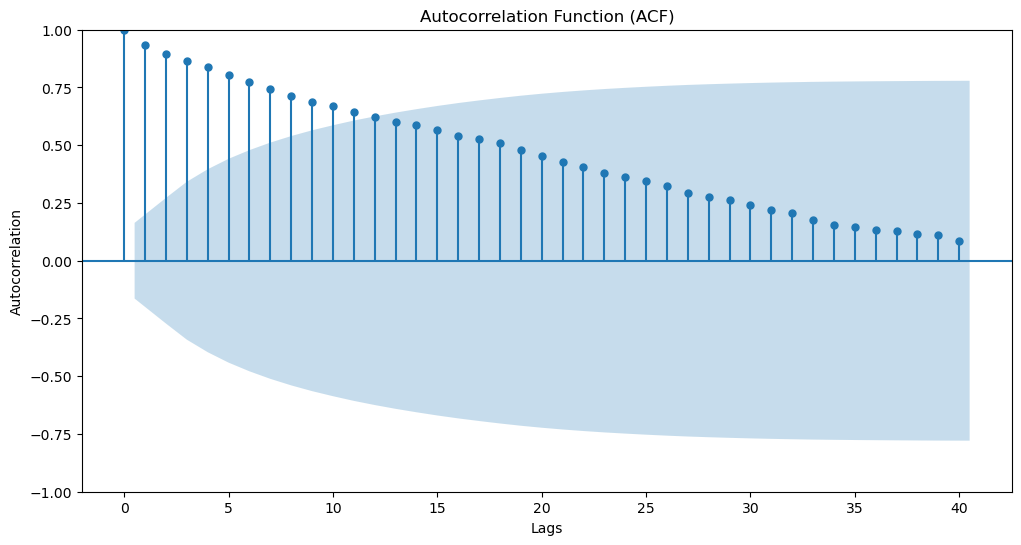

In [73]:
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(temperature_anomaly, lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

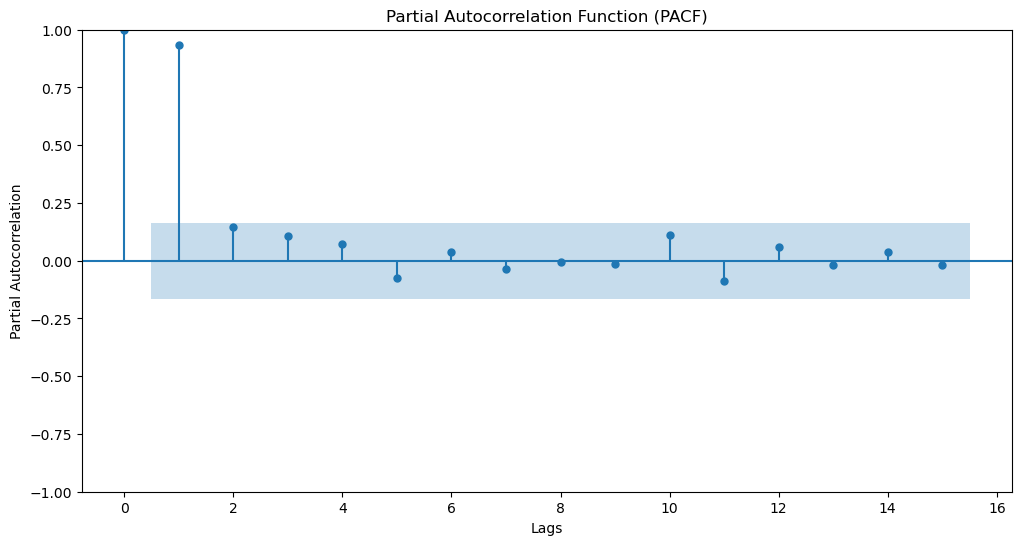

In [74]:
plt.figure(figsize=(12, 6))
plot_pacf(temperature_anomaly, lags=15, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

##### The plots suggests that the data is not stationary

### Implementing Augmented Dicker-Fuller Test for Stationarity

In [75]:
# Performing Augmented Dickey-Fuller test
adf_result = adfuller(temperature_anomaly, autolag='AIC')

# Extracting test statistics and p-value
adf_statistic = adf_result[0]
p_value = adf_result[1]

# Displaying the results
print(f'ADF Statistic: {adf_statistic}')
print(f'P-value: {p_value}')

# Interpreting the results
if p_value <= 0.05:
    print('Reject the null hypothesis. The time series is stationary.')
else:
    print('Fail to reject the null hypothesis. The time series is non-stationary.')


ADF Statistic: 1.001422191182046
P-value: 0.9942809316737001
Fail to reject the null hypothesis. The time series is non-stationary.


##### Differencing the Data to make it stationary

In [79]:
# Performing ADF test for differencing
temperature_anomaly_diff = temperature_anomaly.diff(3).dropna()
adf_result_diff = adfuller(temperature_anomaly_diff.dropna(), autolag='AIC')

# Extracting test statistics and p-value
adf_statistic_diff = adf_result_diff[0]
p_value_diff = adf_result_diff[1]

# Displaying the results
print(f'ADF Statistic (after 1st differencing): {adf_statistic_diff:.5f}')
print(f'P-value (after 1st differencing): {p_value_diff:.20f}')

# Interpreting the results
if p_value_diff <= 0.05:
    print(f'Reject the null hypothesis for 1st differencing. The differenced time series is stationary.')
else:
    print(f'Fail to reject the null hypothesis for 1st differencing. The differenced time series is non-stationary.')

ADF Statistic (after 1st differencing): -3.29753
P-value (after 1st differencing): 0.01498930916954113561
Reject the null hypothesis for 3rd differencing. The differenced time series is stationary.


##### Now our data is ready for ARIMA and SARIMAX Modelling

##### Using ACF and PACF plots for optimal values of ARIMA parameters (p, d, q)

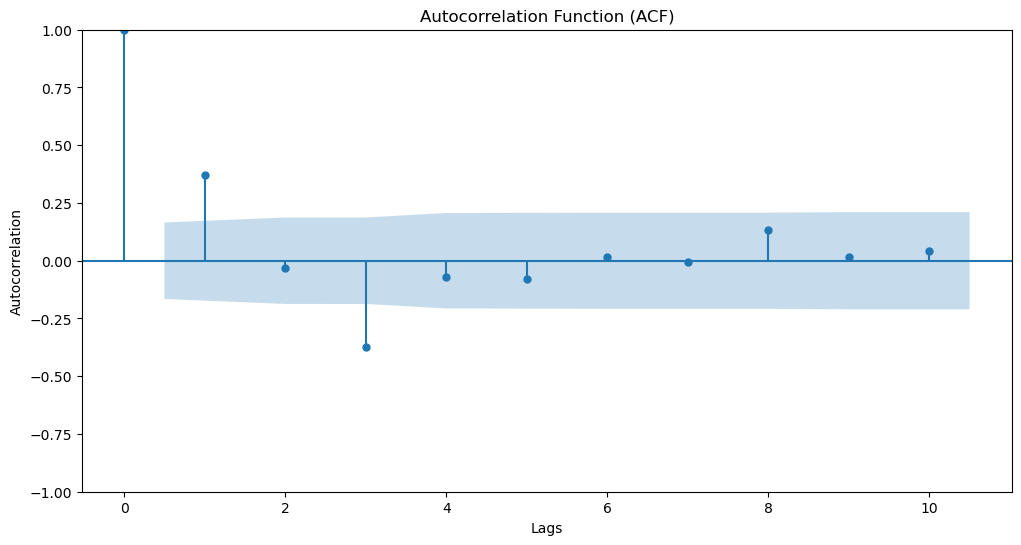

In [82]:
# Plotting ACF on differenced data
plt.figure(figsize=(12, 6))
plot_acf(temperature_anomaly_diff, lags=10, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

##### In the plot, the correlation is negative at lag = 2. Hence, we will choose q = 1 (lag - 1)

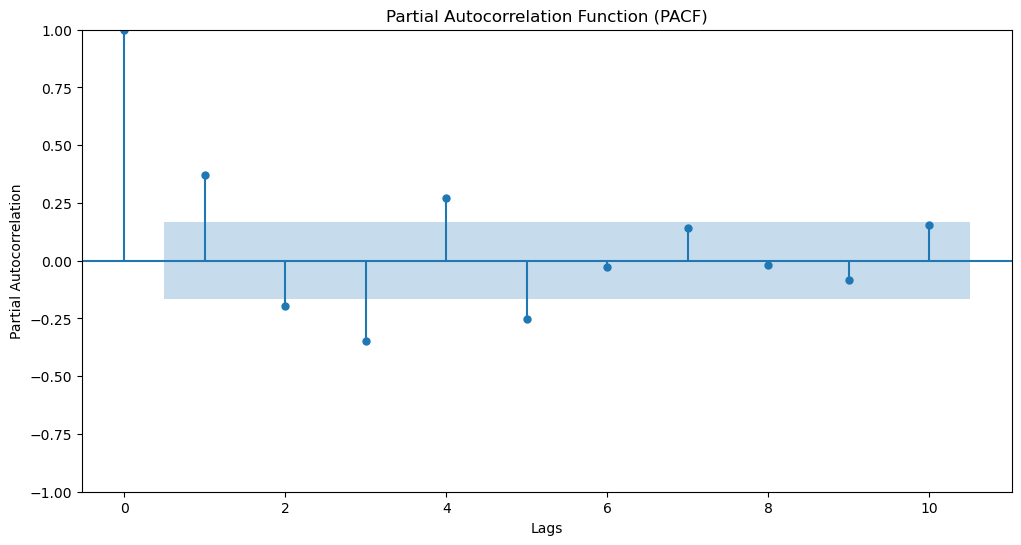

In [83]:
plt.figure(figsize=(12, 6))
plot_pacf(temperature_anomaly_diff, lags=10, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

##### In the plot, the correlation is negative at lag = 2. Hence, we will choose p = 1 (lag - 1)
##### Since we differenced our data to 1st level, we choose d = 1

In [87]:
# Fitting ARIMA model with values p = 1; d = 1; q = 1; 
arima_model = ARIMA(temperature_anomaly_diff, order=(1, 1, 1))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:           temp_anomaly   No. Observations:                  140
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  80.195
Date:                Mon, 11 Dec 2023   AIC                           -154.391
Time:                        19:51:09   BIC                           -145.587
Sample:                    12-31-1883   HQIC                          -150.813
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3771      0.082      4.589      0.000       0.216       0.538
ma.L1         -0.9918      0.059    -16.943      0.000      -1.107      -0.877
sigma2         0.0180      0.003      6.931      0.0

/Users/raunak17/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/raunak17/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


##### Forecasting using the ARIMA model

/Users/raunak17/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


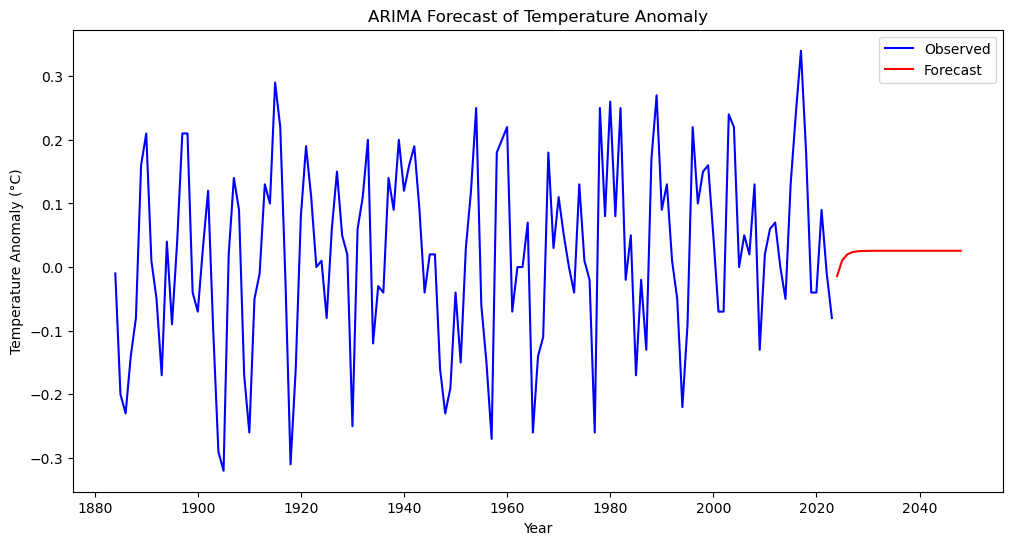

In [88]:
# Forecast future values
forecast_steps = 25
forecast = model.forecast(steps=forecast_steps, alpha=0.05)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(temperature_anomaly_diff, label='Observed', color='blue')
plt.plot(pd.date_range("2023-12-31", periods=forecast_steps, freq="Y"), forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast of Temperature Anomaly')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

##### Evaluating our Model by Creating a Training and Testing Set

Mean Squared Error (MSE): 0.01787242734880146


/Users/raunak17/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


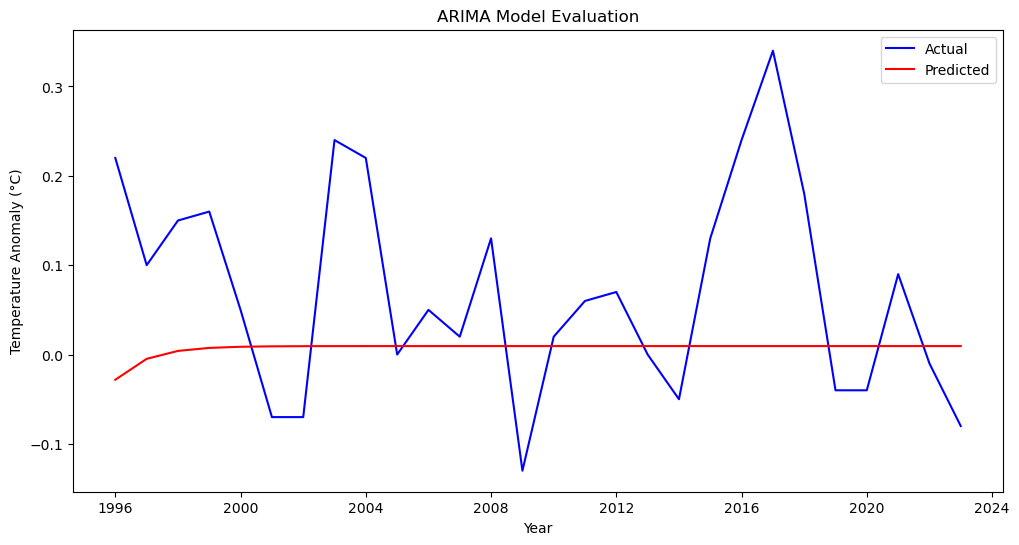

In [89]:
# Split the data into training and test sets
train_size = int(len(temperature_anomaly_diff) * 0.8)
train, test = temperature_anomaly_diff[:train_size], temperature_anomaly_diff[train_size:]

# Fitting the ARIMA model on the training set
arima_model = ARIMA(train, order=(1, 1, 1))
model = arima_model.fit()

# Forecast on the test set
forecast_steps = len(test)
forecast = model.forecast(steps=forecast_steps, alpha=0.05)

# Calculate Mean Squared Error (MSE) as an evaluation metric
mse = mean_squared_error(test, forecast)
print(f'Mean Squared Error (MSE): {mse}')

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, forecast, label='Predicted', color='red')
plt.title('ARIMA Model Evaluation')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()


##### We can see the ARIMA Model did not perform well. Therefore, we will try implementing a enhanced version of ARIMA i.e. STL ARIMA

### Implementing STL ARIMA

/Users/raunak17/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/raunak17/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/raunak17/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


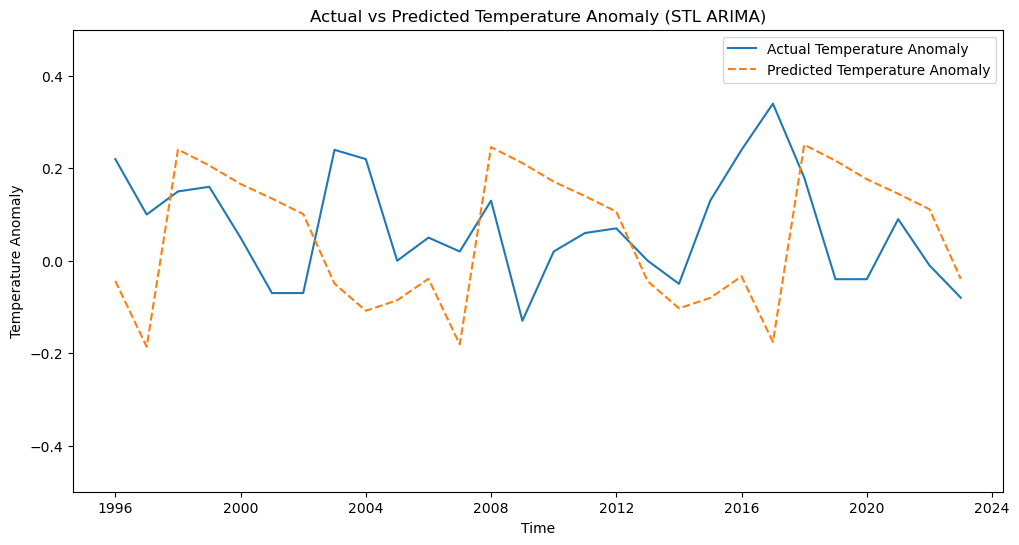

Mean Squared Error: 0.042198547374487534


In [103]:
# Fitting the STLForecast model
stlf = STLForecast(train, ARIMA, period=10, model_kwargs=dict(order=(1, 1, 1), trend="t"))
stlf_res = stlf.fit()

# Forecast on the test set
forecast = stlf_res.forecast(steps=len(test))

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual Temperature Anomaly')
plt.plot(forecast, label='Predicted Temperature Anomaly', linestyle='dashed')
plt.legend()
plt.title('Actual vs Predicted Temperature Anomaly (STL ARIMA)')
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly')
plt.ylim(-0.5, 0.5)
plt.show()

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error: {mse}")

In [91]:
print(stlf_res.summary())

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                  112
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  95.777
Date:                Mon, 11 Dec 2023   AIC                           -183.555
Time:                        19:56:09   BIC                           -172.717
Sample:                    12-31-1883   HQIC                          -179.158
                         - 12-31-1994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0005      0.001      0.859      0.390      -0.001       0.002
ar.L1          0.4463      0.098      4.573      0.000       0.255       0.638
ma.L1         -0.9996      4.538     -0.220      0.8

##### Making forecasts using the STL ARIMA Model

/Users/raunak17/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/raunak17/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/raunak17/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


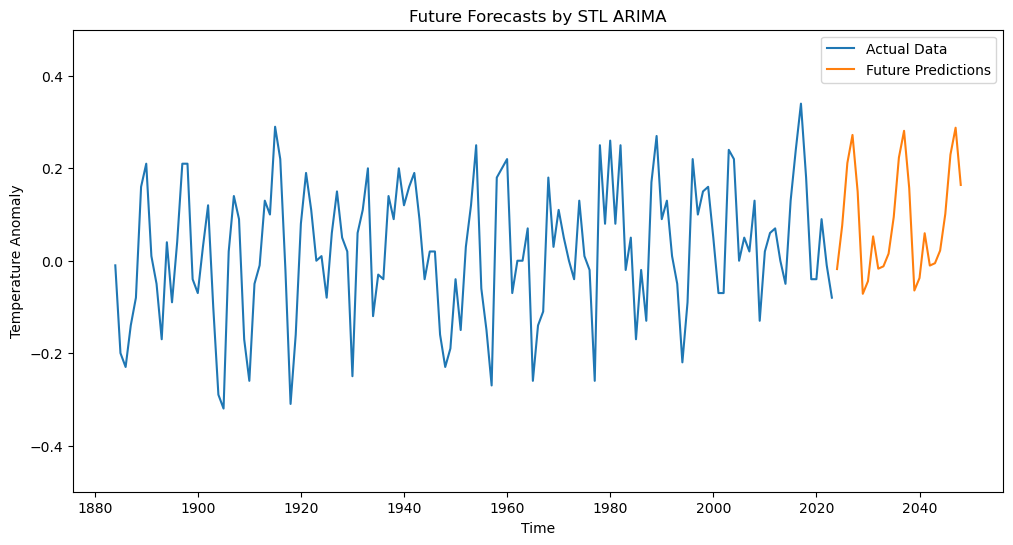

In [99]:
# Fitting the Model on Entire Dataset
stlf = STLForecast(temperature_anomaly_diff, ARIMA, period = 10 ,model_kwargs=dict(order=(1, 1, 1), trend="t"))
stlf_res = stlf.fit()

# Making future forecasts using STL ARIMA
forecast = stlf_res.forecast(25)

# # Plotting the Actual and Future Predictions
plt.figure(figsize=(12, 6))
plt.plot(temperature_anomaly_diff, label = 'Actual Data')
plt.plot(forecast, label = 'Future Predictions')
plt.title('Future Forecasts by STL ARIMA')
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly')
plt.legend()
plt.ylim(-0.5, 0.5)
plt.show()

##### We got much better results from ARIMA model. This is because STL ARIMA decomposes time series into three components which are seasonal, trend and remainder. It then implements ARIMA on the remainder part which helps it to better understand the trend in the time series.

### SARIMAX Model

We chose SARIMAX model because it explicitly models seasonality, making it well-suited for time series data with clear periodic patterns. 

For Sarimax,
We will use the same p,d,q values we did for ARIMA

For the seasonal parameters, we will try a combination if different values ranging from 0 to 3 and tune the best values which get optimal results

In [96]:
# Define your non-seasonal ARIMA order
p, d, q = 1, 1, 1

# Define ranges for seasonal parameters
seasonal_p_values = range(0, 3)
seasonal_d_values = range(0, 3)
seasonal_q_values = range(0, 3)
s_values = [12]  

seasonal_order = list(product(seasonal_p_values, seasonal_d_values, seasonal_q_values, s_values))

best_score, best_params = float("inf"), None

for order in seasonal_order:
    try:
        # Fit SARIMA model with pre-defined non-seasonal parameters
        model = SARIMAX(train, order=(p, d, q), seasonal_order=order)
        results = model.fit(disp=False)
        # Make predictions on the validation set
        predictions = results.get_forecast(steps=len(test))
        mse = mean_squared_error(test, predictions.predicted_mean)
        if mse < best_score:
            best_score, best_params = mse, order
    except:
        continue

print(f"Non-Seasonal ARIMA Order: ({p}, {d}, {q})")
print(f"Best Seasonal Order: {best_params}")


/Users/raunak17/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/raunak17/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/raunak17/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/raunak17/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Usin

Non-Seasonal ARIMA Order: (1, 1, 1)
Best Seasonal Order: (0, 1, 1, 12)


##### Fitting the model with best parameters

In [97]:
final_model = SARIMAX(train, order=(p, d, q), seasonal_order=best_params)
final_results = final_model.fit(disp=False)
print(final_results.summary())

/Users/raunak17/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/raunak17/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                       temp_anomaly   No. Observations:                  112
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  37.539
Date:                            Mon, 11 Dec 2023   AIC                            -67.078
Time:                                    20:03:45   BIC                            -56.698
Sample:                                12-31-1883   HQIC                           -62.878
                                     - 12-31-1994                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3921      0.125      3.133      0.002       0.147       0.637
ma.L1         -0.9981      2.099   

##### Evaluating the Model

Final SARIMA Model MSE on Test Set: 0.014287349059821373


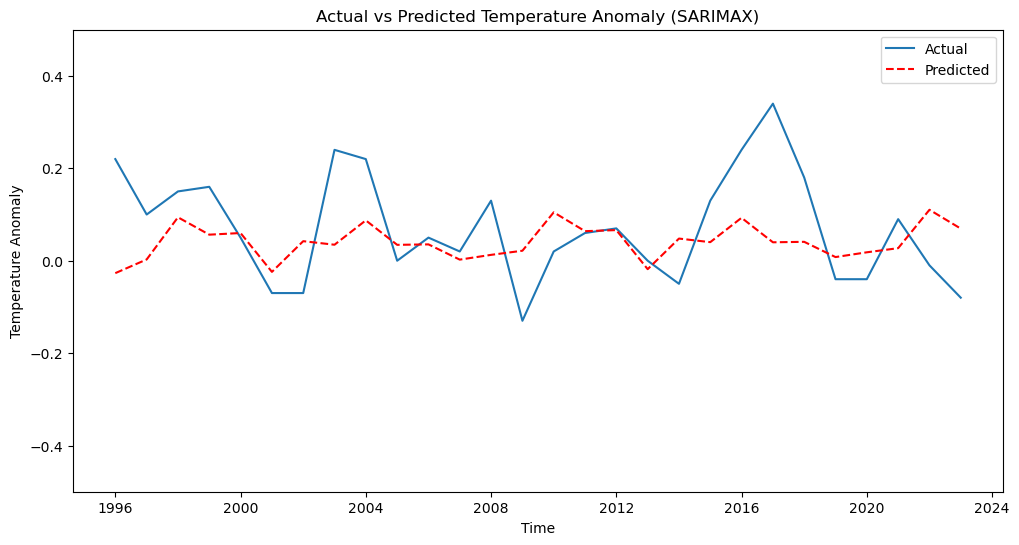

In [104]:
# Make predictions on the test set
predictions = final_results.get_forecast(steps=len(test))

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(test, predictions.predicted_mean)
print(f"Final SARIMA Model MSE on Test Set: {mse}")

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual')
plt.plot(predictions.predicted_mean, label='Predicted', color='red', linestyle='dashed')
plt.title('Actual vs Predicted Temperature Anomaly (SARIMAX)')
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly')
plt.legend()
plt.ylim(-0.5, 0.5)
plt.show()


##### Making Future Predictions

/Users/raunak17/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/raunak17/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/raunak17/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


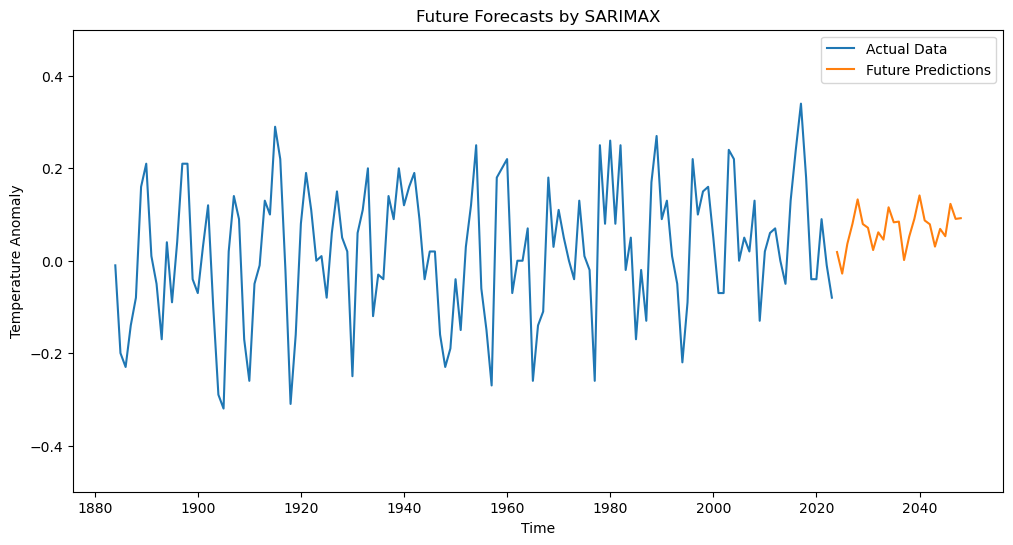

In [101]:
# Fitting the Model on Entire Dataset
sarimax_model = SARIMAX(temperature_anomaly_diff, order=(p, d, q), seasonal_order=best_params)
sarimax_results = sarimax_model.fit(disp=False)

# Making future forecasts using SARIMAX
sarimax_forecast = sarimax_results.forecast(25)

# Plotting the Actual and Future Predictions
plt.figure(figsize=(12, 6))
plt.plot(temperature_anomaly_diff, label = 'Actual Data')
plt.plot(sarimax_forecast, label = 'Future Predictions')
plt.title('Future Forecasts by SARIMAX')
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly')
plt.legend()
plt.ylim(-0.5, 0.5)
plt.show()


